# SSVEP Decoding Framework
 I want to build a general pipeline for SSVEP EEG signal decoding, in which it is easy to complete basic EEG processing stages like:
 * cutting and slicing your data
 * filtering data
 * applying feature extraction method
 *  matching pattern and get result

The key inspiration of the framework design ethic is modular, and I want to take the manually parts like experimental information, special filters and feature extraction methods out of the main executing. So that it's much easier to re-write or add new minds into the framework. In the other words, it is a framework that flexible, easy for new learner and try something new.

There are 3 main class defined in this framework. If you just focus on get model for online experiment or do some cross validation, the `data_runner` class and `data_cross_validation` class are what you need, you can just read through and run them. In the `filter_apply` class, you can configure your own time-filter parameters, and what I must admit is that the filter parameters in the current version is not the best, and haven't been optimized at all! 

You may notice that there are several functions above the main classes, they can be named as helper functions. I can move them together and separate them to a helper collection and make the main program clear.

## Import necessary external packages here
 
In this framework, I try to use external packages as little as possible. Compared to use the toolbox like mne, it's a bit of troublesome, but not too much. Jump out of the mne processing and data framework can make you understand the data routine more clearly.

However, if you like, you can feel free add some packages for boosting the function of the framework.

In [2]:
from multiprocessing import set_forkserver_preload
from os.path import join as pjoin
from tkinter.filedialog import test
from turtle import mode
import numpy as np
import scipy.signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.io import loadmat
import json
from collections import defaultdict
from matplotlib import pyplot as plt

# Manully packages and funtions
from helper_functions import *

In [3]:
class data_trainer():
    """
    
    """
    def __init__(self, data, data_info, spatial_filter_type='TRCA') -> None:
        self.template_storage = dict()
        self.slice_data_storage = data
        self.spatial_filter_type = spatial_filter_type
        self.event_series = self.slice_data_storage.keys()
        self.epochs_in_data = data_info['epochs_in_data']
        self.blocks_in_data = data_info['blocks_in_data']
    
    def model_train(self):
        """
        Method to train feature extracting model by iteracting the dict keys, which map to all kind of triggers data.
        """
        self.spatial_filters = dict()
        for train_trial_iter in self.event_series:
            train_epochs = np.array(self.slice_data_storage[train_trial_iter])
            self.spatial_filters[train_trial_iter] = self.feature_extract(train_epochs)
            self.template_calculate(train_epochs, train_trial_iter)

    def feature_extract(self,data):
        """
        Define of call your manully feature extraction methods here.
        """
        if self.spatial_filter_type == 'TRCA':
            return trca_matrix(data)
        if self.spatial_filter_type == 'TDCA':
            pass
        raise Exception('Method not define, you can define it manually!')
    
    def template_calculate(self, train_data, event_type):
        self.template_storage[event_type] = np.mean(train_data, axis=0)
        self.template_events = list(self.template_storage.keys())
    
    def get_model(self):
        return self.spatial_filters, self.template_storage, self.event_series

In [4]:
class data_cross_validation(data_trainer):
    
    def cross_validation_runner(self):
        self.dataset_split_index = train_test_split(split_type='K_Fold',test_sample_num=self.epochs_in_data, total_sample_num=self.epochs_in_data*self.blocks_in_data)
        self.result_saver = result_analyser(self.event_series,self.dataset_split_index.shape[0],self.epochs_in_data, data_type = 'offline', LDA = 'train', OVERLAP = 3)
        for cross_validation_iter in range(self.dataset_split_index.shape[0]):
            self.CV_iter = cross_validation_iter
            print('cross validation loop: {}'.format(cross_validation_iter))
            validation_index = self.dataset_split_index[cross_validation_iter,:]
            self.trainer(1-validation_index)
            self.tester(validation_index)
        self.result_saver.ACC_calculate()
    
    def trainer(self,select_index):
        self.spatial_filters = dict()
        for train_trial_iter in self.event_series:
            self.spatial_filters[train_trial_iter] = self.feature_extract(np.array(self.slice_data_storage[train_trial_iter])[select_index==1,:,:])
            self.template_calculate(np.array(self.slice_data_storage[train_trial_iter])[select_index==1,:,:],train_trial_iter)
    
    def tester(self,select_index):
        self.corrcoef_storage = dict()
        for test_trial_iter in self.event_series:
            test_epoches = np.array(self.slice_data_storage[test_trial_iter])[select_index==1,:,:]
            # corrcoef_list = self.corrcoef_storage.setdefault(test_trial_iter, list())
            for test_epoch_iter in range(test_epoches.shape[0]):
                coef_vector = pattern_match(test_epoches[test_epoch_iter,:,:],self.spatial_filters,self.template_storage)
                # corrcoef_list.append(coef_vector)
                self.result_saver.result_decide(coef_vector,self.CV_iter,test_trial_iter,test_epoch_iter)

    def train_lda(self):
        self.result_saver.LDA_model_builder.train_model()
        return self.result_saver.LDA_model_builder

In [5]:
class simulated_online():
    def __init__(self, data, data_info, model):
        self.data = data['data']
        self.epochs_in_data = data_info['epochs_in_data']
        self.spatial_filters = model['spatial_filters']
        self.template_storage = model['template_storage']
        self.event_series = data['label']
        self.result_saver = result_analyser(model['event_series'], CV_loops = 1, epoch_num=self.epochs_in_data, data_type='simu_online',  OVERLAP = 3, LDA = 'test', LDA_model = model['LDA_model'])
        self.epoch_count = 0
    
    def tester(self):
        for test_epoch_iter in range(len(self.event_series)):
            test_epoches = np.array(self.data[test_epoch_iter])
            corrcoef_storage = pattern_match(test_epoches, self.spatial_filters, self.template_storage)
            self.result_saver.result_decide(corrcoef_storage, 1, self.event_series[test_epoch_iter]-1, self.epoch_count)
            self.epoch_count += 1

In [6]:
def offline_data_runner(usrname='S01', data_path='./raw_data/',block_num='block2'):
    data_loader = data_preprocessor_raw(usrname, data_path, block_num)
    data_loader.read_config_file()
    data_loader.read_data()
    data_loader.slice_data()
    packaged_data, data_info = data_loader.send_data()
    model_trainer = data_trainer(packaged_data, data_info)
    model_trainer.model_train()
    spatial_filters, template_storage, event_series = model_trainer.get_model()
    cross_validation_object = data_cross_validation(packaged_data, data_info)
    cross_validation_object.cross_validation_runner()
    
    lda_model = cross_validation_object.train_lda()
    
    model = dict()
    model['spatial_filters'] = spatial_filters
    model['template_storage'] = template_storage
    model['LDA_model'] = lda_model
    model['event_series'] = event_series
    
    return model

In [7]:
def simulated_online_runner(usrname='S01', data_path='./raw_data/', block_num='simu_block2',model = None):
    data_loader = data_preprocessor_raw(usrname, data_path, block_num, data_type='simu_online')
    data_loader.read_config_file()
    data_loader.read_data()
    data_loader.slice_data()
    packaged_data, data_info = data_loader.send_data()
    simulated_online_object = simulated_online(packaged_data, data_info, model)
    simulated_online_object.tester()

Extracting EDF parameters from /Users/meijie/Documents/Code/Drone_EEG_Process/raw_data/S01/block2/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/meijie/Documents/Code/Drone_EEG_Process/raw_data/S01/block2/evt.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
mne version > 0.20
Note: The raw continuous data has been sliced by its event triggers
Note: There are 12 unique triggers in raw data
Note: Data check passed, all triggers have same epochs, which is 30
cross validation loop: 0
ACC of the 0 cross validation loop is: 1.0
cross validation loop: 1
ACC of the 1 cross validation loop is: 1.0
cross validation loop: 2
ACC of the 2 cross validation loop is: 1.0
cross validation loop: 3
ACC of the 3 cross validation loop is: 0.7777777777777778
cross validation loop: 4
ACC of the 4 cross validation loop is: 0.9722222222222222
cross validation loop: 5
ACC of the 5 cross

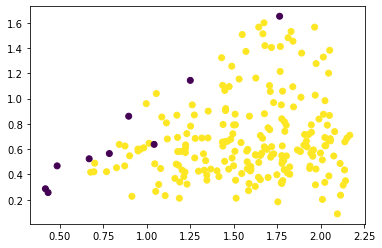

Extracting EDF parameters from /Users/meijie/Documents/Code/Drone_EEG_Process/raw_data/S01/simu_block2/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/meijie/Documents/Code/Drone_EEG_Process/raw_data/S01/simu_block2/evt.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
mne version > 0.20
NOTE: LDA was applied to verify the result.
NOTE: This is confusing matrix:
TP:185.0	TN:5.0
FP:31.0	FN:17.0
Precision:0.9158415841584159	Recall:0.9158415841584159


In [8]:
if __name__ == '__main__':
    model = offline_data_runner()
    simulated_online_runner(model=model)